In [ ]:
%%capture
%pip install einops pytorch_lightning diffusers==0.12.1 kornia librosa accelerate torchvision pandas==1.5.2

In [1]:
import torch
import pytorch_lightning as pl

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from src import *

mpl.rcParams['figure.figsize'] = (8, 8)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.Size([1, 256, 256])


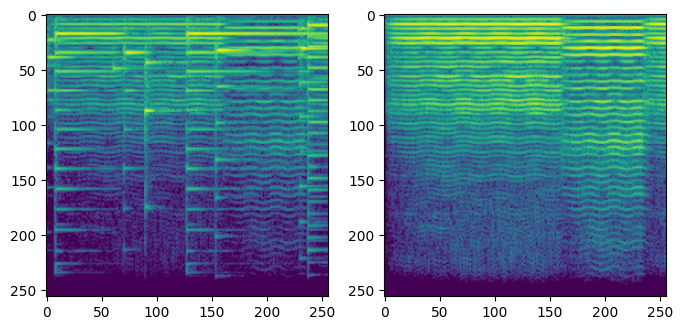

In [2]:
from dataset import SpectrogramDataset

train_ds=SpectrogramDataset(target_dir='datasets/randomMIDI/PianoViolin11025/WAV/train/ins3',
                            condition_dir='datasets/randomMIDI/PianoViolin11025/WAV/train/mix',
                            return_pair=True,
                            out_channels=1
                     )


valid_ds=SpectrogramDataset(target_dir='datasets/randomMIDI/PianoViolin11025/WAV/val/ins3',
                          condition_dir='datasets/randomMIDI/PianoViolin11025/WAV/val/mix',
                          return_pair=True,
                          out_channels=1
                     )

test_ds=SpectrogramDataset(target_dir='datasets/randomMIDI/PianoViolin11025/WAV/test/ins3',
                           condition_dir='datasets/randomMIDI/PianoViolin11025/WAV/test/mix',
                           return_pair=True,
                           out_channels=1
                     )

img1,img2=train_ds[0]
print(img1.shape)

plt.subplot(1,2,1)
plt.imshow(img1.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(img2.permute(1,2,0))

In [15]:
class plUnet(pl.LightningModule):
    def __init__(self,
                 train_dataset,
                 valid_dataset,
                 batch_size,
                 lr=1e-4,
                 warm_up_steps=10000,
                 loss_fn=torch.nn.functional.l1_loss):
        super().__init__()
        self.save_hyperparameters()
        self.train_dataset=train_dataset
        self.valid_dataset=valid_dataset
        self.batch_size=batch_size
        self.lr=lr
        self.warm_up_steps= warm_up_steps
        self.loss_fn = loss_fn

        channels, h, w = train_dataset[0][0].shape

        self.model=UnetConvNextBlock(dim=64,
                                     dim_mults = (1,2,4,8),
                                     channels=channels*2,
                                     out_dim=channels,
                                     with_time_emb=False)
        
        print(self.model)
        
    def forward(self, x):
        return self.output_T(self.model(self.input_T(x)))
    
    def input_T(self, input):
        # By default, let the model accept samples in [0,1] range, and transform them automatically
        return (input.clip(0,1).mul_(2)).sub_(1)
    
    def output_T(self, input):
        # Inverse transform of model output from [-1,1] to [0,1] range
        return (input.add_(1)).div_(2)
    
    def training_step(self, batch, batch_idx):
        mix, source = batch
        print(mix.shape, source.shape)
        model_output=self.model(self.input_T(mix))

        loss = self.loss_fn(model_output, self.input_T(source))
        
        self.log('train_loss',loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        mix, source = batch
        print(mix.shape, source.shape)
        model_output=self.model(self.input_T(mix))

        loss = self.loss_fn(model_output, self.input_T(source))
        
        self.log('train_loss',loss, prog_bar=True)
        return loss
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset,
                          batch_size=self.batch_size,
                          shuffle=True,
                          num_workers=4)
    
    def val_dataloader(self):
        if self.valid_dataset is not None:
            return DataLoader(self.valid_dataset,
                              batch_size=self.batch_size,
                              shuffle=False,
                              num_workers=4)
        else:
            return None
        
    def configure_optimizers(self):
        return  torch.optim.AdamW(list(filter(lambda p: p.requires_grad, self.model.parameters())), lr=self.lr)
    
    def optimizer_step(self, epoch, 
                       batch_idx, 
                       optimizer,
                       optimizer_closure):
        
        # Linear Warm-up
        if self.trainer.global_step < self.warm_up_steps:
            lr_scale = min(1.0, float(self.trainer.global_step + 1) / self.warm_up_steps)
            for pg in optimizer.param_groups:
                pg["lr"] = lr_scale * self.lr

        optimizer.step(closure=optimizer_closure)

        self.log('lr', pg['lr'], prog_bar=True)

        return super().optimizer_step(epoch, batch_idx, optimizer, optimizer_closure)
    
model = plUnet(train_dataset=train_ds,
               valid_dataset=valid_ds,
               batch_size=8)

Is Time embed used ?  False


In [16]:
trainer = pl.Trainer(
    default_root_dir="trained_models/unet/",
    max_epochs=2000,
    callbacks=[EMA(0.9999)],
    accelerator='auto'
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [17]:
trainer.fit(model)


  | Name  | Type              | Params
--------------------------------------------
0 | model | UnetConvNextBlock | 56.3 M
--------------------------------------------
56.3 M    Trainable params
0         Non-trainable params
56.3 M    Total params
225.109   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])


RuntimeError: Given groups=2, weight of size [2, 1, 7, 7], expected input[8, 1, 256, 256] to have 2 channels, but got 1 channels instead